# Advanced Lane Lines

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.misc import imresize
import cv2

print("All module loaded")

Using TensorFlow backend.


All module loaded


## Calibrating

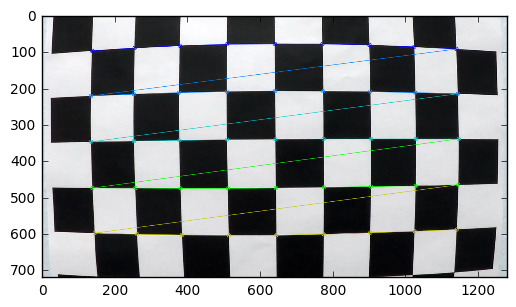

In [37]:

# Construct arrays for center, right and left images of controlled driving
images = np.asarray(os.listdir("camera_cal/"))

chess_data= []

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

count = 0
for image in images:
    image_file = os.path.join('camera_cal/', image)
    image_data = cv2.imread(image_file)
    gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
    # If found, add object points, image points (after refining them)
    chess_data.append(image_data)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image_data, (9,5), corners2, ret)
#         print(""true"")
#         plt.imshow(image_data)

        
#     #     chess_data[count] = image_data
#     break
%matplotlib inline
plt.imshow(chess_data[0])


# plt.imshow(image_data[0])

# print(len(image_data))

## Distortion Correction

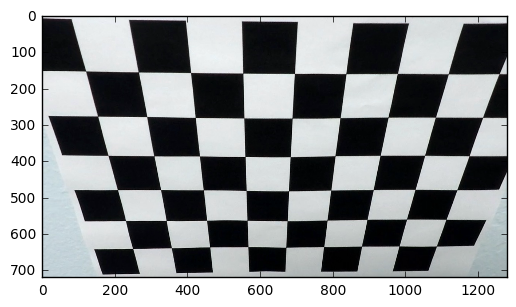

In [50]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist = cv2.undistort(chess_data[11], mtx, dist, None, mtx)
%matplotlib inline
plt.imshow(undist)

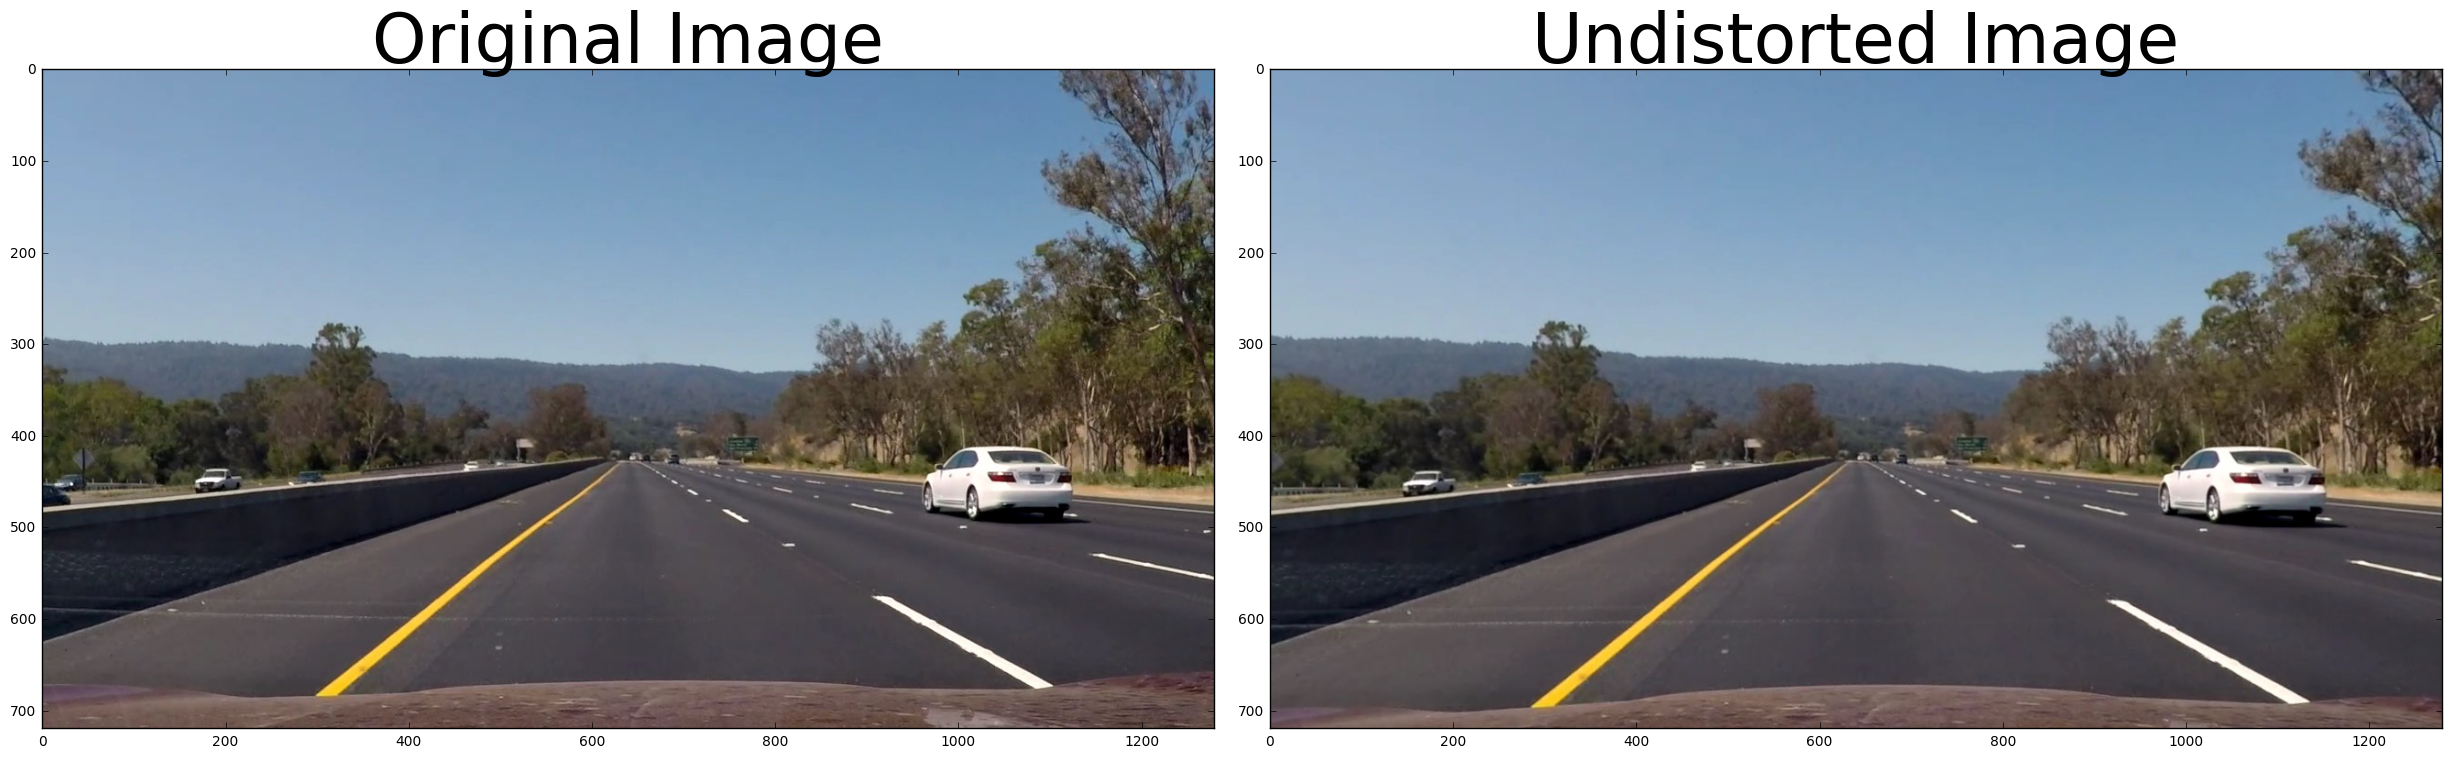

In [106]:
imageTest = mpimg.imread('perspective_straight.jpg')
undistTest = cv2.undistort(imageTest, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(imageTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistTest)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Threshold

In [173]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3,thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img,thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
#     retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    return s_binary
    

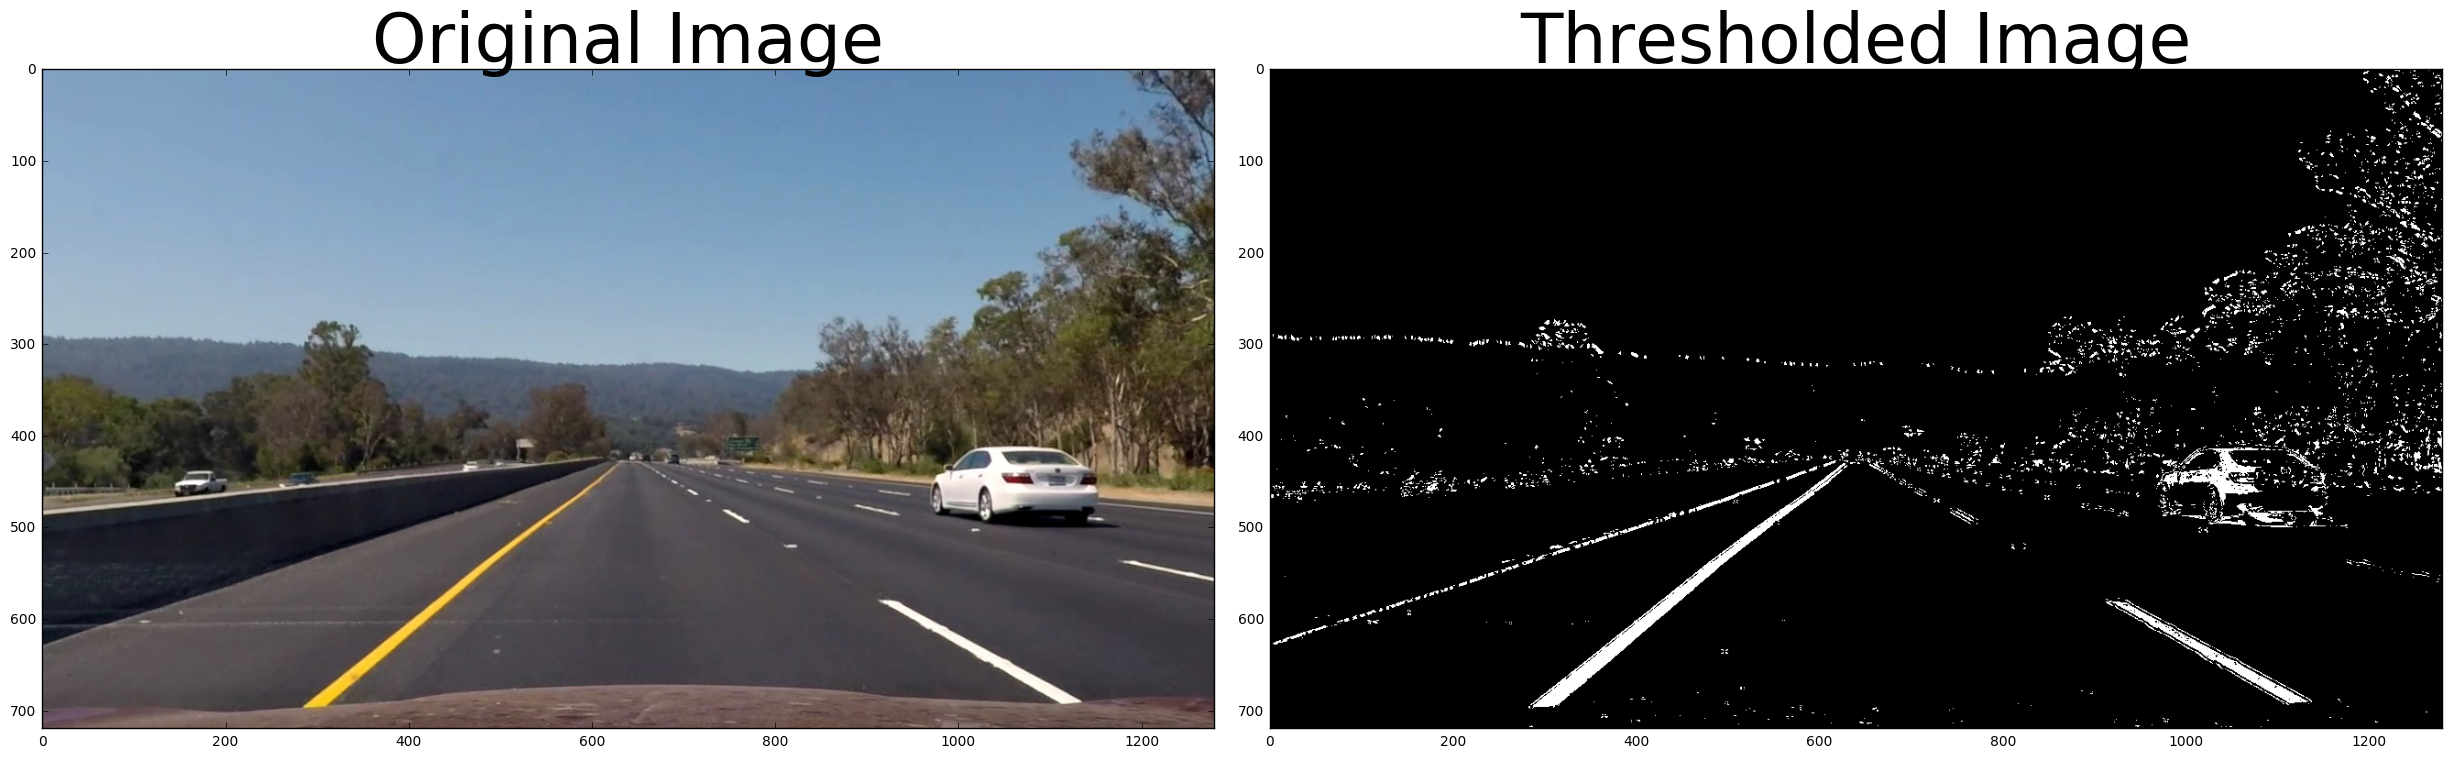

In [182]:
imageTest = mpimg.imread('perspective_straight.jpg')
undistTest = cv2.undistort(imageTest, mtx, dist, None, mtx)
ksize = 5

# # Run the function
# grad_binary = abs_sobel_thresh(undistTest, orient='y',sobel_kernel = 15, thresh=(50,100))
# # Plot the result
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(undistTest)
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(grad_binary, cmap='gray')
# ax2.set_title('Thresholded Gradient', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undistTest, orient='x', sobel_kernel=3, thresh=(50, 100))
grady = abs_sobel_thresh(undistTest, orient='y', sobel_kernel=3, thresh=(50, 100))
mag_binary = mag_thresh(undistTest, sobel_kernel=5, mag_thresh=(30, 100))
dir_binary = dir_threshold(undistTest, sobel_kernel=7, thresh=(0.7, 1.3))


color_binary = color_threshold(undistTest,thresh=(150,255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined,cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective Transform

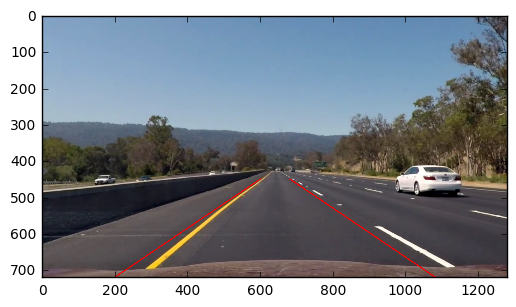

In [104]:
cv2.line(undistTest, (200, 720), (600, 450), [255,0,0], 2)
cv2.line(undistTest, (1080, 720), (680, 450), [255,0,0], 2)           
plt.imshow(undistTest)

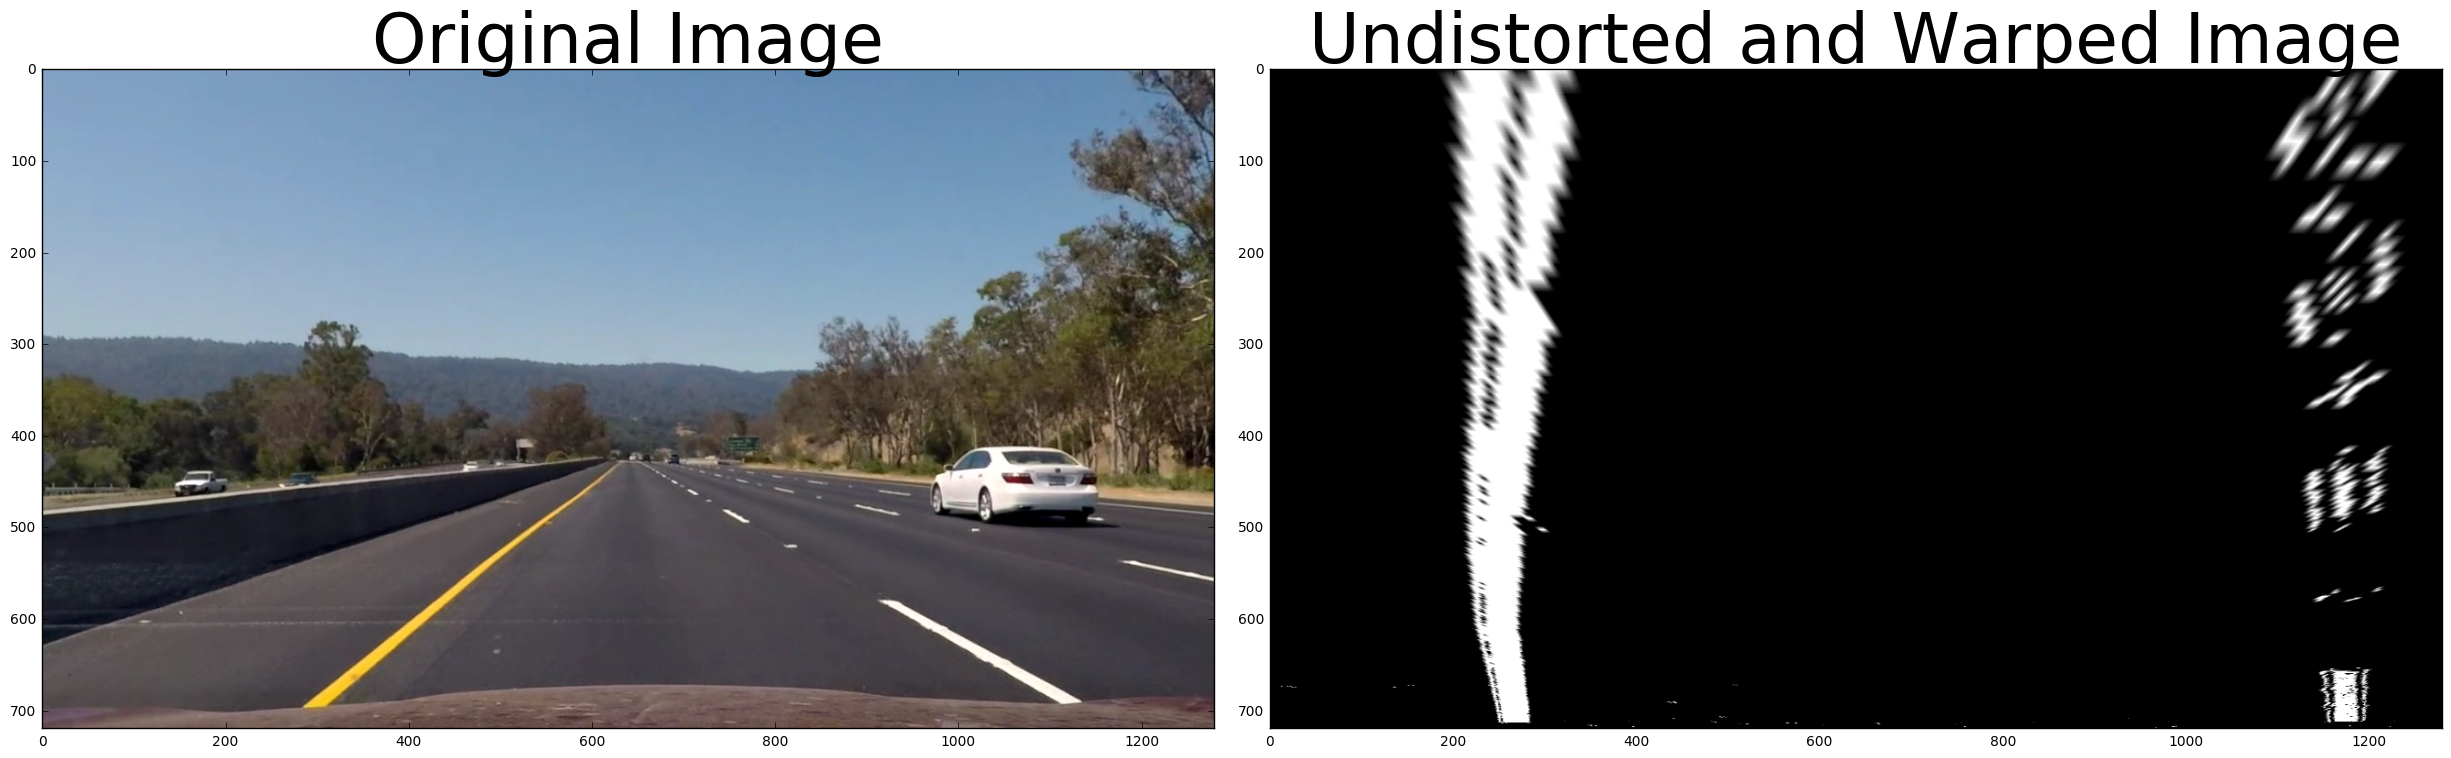

In [183]:
src = np.float32([[600, 450], [680, 450],[1080, 720],[200, 720]])
dst = np.float32([[200, 0], [1080, 0],[1080, 720],[200, 720]])
M = cv2.getPerspectiveTransform(src, dst)

img_size = (combined.shape[1], combined.shape[0])
#Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
       
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistTest)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


/Users/zhongming/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


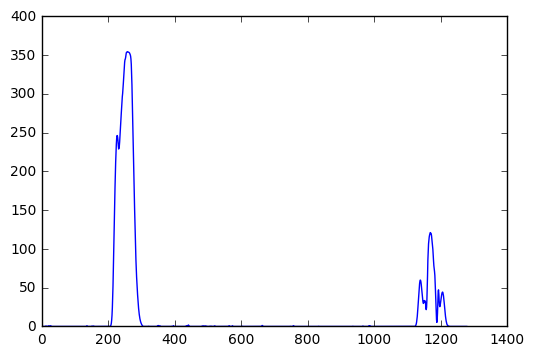

In [184]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [208]:
histogram_left = histogram[0:len(histogram)/2]
histogram_right = histogram[len(histogram)/2:len(histogram)]

idx_l = np.argmax(histogram_left)
idx_r = np.argmax(histogram_right)


for i in range(0,6):
    j = 5-i
    img_j = warped[warped.shape[0]/6*j : warped.shape[0]/6*(j+1),:]
    img_j_left = img_j[:,0:len(img_j[0])/2]
    img_j_right = img_j[:,len(img_j[0])/2:len(img_j[0])]
    
    left_window = img_j_left[:,idx_l - 100:idx_l+100]
    right_window = img_j_right[:,idx_r - 100:idx_r+100]
    
    hist_l_window = np.sum(left_window[:,:], axis=0)
    hist_r_window = np.sum(right_window[:,:], axis=0)
    
    idx_l_window = np.argmax(hist_l_window)
    idx_r_window = np.argmax(hist_r_window)
    

plt.imshow(left_window,cmap='gray') 
# plt.plot(hist_l_window)
    

/Users/zhongming/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/zhongming/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/zhongming/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/zhongming/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/zhongming/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWar

In [93]:
# # Get steering angles for recovery driving weaving out to the right 
# recovery_angles = pd.read_csv('Recovery/driving_log.csv', header = None)
# recovery_angles.columns = ('Center Image','Left Image','Right Image','Steering Angle','Throttle','Brake','Speed')
# recovery_angles = np.array(recovery_angles['Steering Angle'])

# # Construct array for recovery driving images
# recovery_images = np.asarray(os.listdir("Recovery/IMG/"))
# recovery_images = recovery_images[0:] # To ignore .DS_store on mac
# recovery = np.ndarray(shape=(len(recovery_angles), resizedY, resizedX, 3))

# # Populate recovery driving dataset
# count = 0
# for image in recovery_images:
#     if image.startswith('center'):
#         image_file = os.path.join('Recovery/IMG', image)
#         image_data = mpimg.imread(image_file)
#         image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2YUV)
#         image_data[:,:,0] = cv2.equalizeHist(image_data[:,:,0])
#         recovery[count] = imresize(image_data, (resizedOY,resizedX,3))[resizedCrop:,:,:]
#         count += 1
# %matplotlib inline
# plt.imshow(recovery[0])

In [94]:
# # Get steering angles for recovery driving weaving out to the left 
# recovery_left_angles = pd.read_csv('Recovery_left/driving_log.csv', header = None)
# recovery_left_angles.columns = ('Center Image','Left Image','Right Image','Steering Angle','Throttle','Brake','Speed')
# recovery_left_angles = np.array(recovery_left_angles['Steering Angle'])

# # Construct array for recovery driving images
# recovery_left_images = np.asarray(os.listdir("Recovery_left/IMG/"))
# recovery_left_images = recovery_left_images[0:] # To ignore .DS_store on mac
# recovery_left = np.ndarray(shape=(len(recovery_left_angles), resizedY, resizedX, 3))

# # Populate recovery driving dataset
# count = 0
# for image in recovery_left_images:
#     if image.startswith('center'):
#         image_file = os.path.join('Recovery_left/IMG', image)
#         image_data = mpimg.imread(image_file)
#         image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2YUV)
#         image_data[:,:,0] = cv2.equalizeHist(image_data[:,:,0])
#         recovery_left[count] = imresize(image_data, (resizedOY,resizedX,3))[resizedCrop:,:,:]
#         count += 1
# %matplotlib inline
# plt.imshow(recovery_left[0])

In [95]:
# # Get steering angles for recovery driving weaving out to the left 
# recovery_left_angles = pd.read_csv('Recovery_left/driving_log.csv', header = None)
# recovery_left_angles.columns = ('Center Image','Left Image','Right Image','Steering Angle','Throttle','Brake','Speed')
# recovery_left_angles = np.array(recovery_left_angles['Steering Angle'])

# # Construct array for recovery driving images
# recovery_left_images = np.asarray(os.listdir("Recovery_left/IMG/"))
# recovery_left_images = recovery_left_images[0:] # To ignore .DS_store on mac
# recovery_left = np.ndarray(shape=(len(recovery_left_angles), 20, 64, 3))

# # Populate recovery driving dataset
# count = 0
# for image in recovery_left_images:
#     if image.startswith('center'):
#         image_file = os.path.join('Recovery_left/IMG', image)
#         image_data = mpimg.imread(image_file)
#         image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2YUV)
#         image_data[:,:,0] = cv2.equalizeHist(image_data[:,:,0])
#         recovery_left[count] = imresize(image_data, (32,64,3))[12:,:,:]
#         count += 1
# %matplotlib inline
# plt.imshow(recovery_left[0])


# randomYUV = np.ndarray(shape=(X_train.shape))
# im_out = np.ndarray(shape=[X_train[0].shape[0],X_train[0].shape[1]])
# im = np.ndarray(shape=[X_train[0].shape[0],X_train[0].shape[1],3])

# count = 0
# for i in range(len(X_train)):
#     im = np.copy(X_train[i])
#     alpha = (np.random.random()-0.5)*0.1 + 1
#     beta = 0
#     channel = (int)(np.random.random()*3)
#     im_channel = im[:,:,channel]
#     cv2.convertScaleAbs(im_channel,im_out,alpha,beta)
#     im[:,:,channel] = im_out
#     randomYUV[count] = im
#     count += 1


# plt.imshow(X_train[0])
# # Combine regular features/labels with random features/labels
# X_train = np.concatenate((X_train, randomYUV), axis=0)
# y_train = np.concatenate((y_train, y_train),axis=0)


In [107]:
# Concatenate all arrays in to combined training dataset and labels
# for left and right cameras, we add one more 0.1 angles to make harder left or right turn for training
X_train = np.concatenate((center, right, left), axis=0)
y_train = np.concatenate((angles, (angles - .2), (angles + .2)),axis=0)

# # Create a mirror image to create more training set
# mirror = np.ndarray(shape=(X_train.shape))
# count = 0
# for i in range(len(X_train)):
#     mirror[count] = np.fliplr(X_train[i])
#     count += 1
# mirror.shape

# # Create mirror image labels
# mirror_angles = y_train * -1

# # # Combine regular features/labels with mirror features/labels
# X_train = np.concatenate((X_train, mirror), axis=0)
# y_train = np.concatenate((y_train, mirror_angles),axis=0)

# # Randomly adjust Y,U,V Channel to make the training data set more robust
# randomYUV = np.ndarray(shape=(X_train.shape))
# im_out = np.ndarray(shape=[X_train[0].shape[0],X_train[0].shape[1]])
# im = np.ndarray(shape=[X_train[0].shape[0],X_train[0].shape[1],3])

# count = 0
# for i in range(len(X_train)):
#     im = np.copy(X_train[i])
#     alpha = (np.random.random()-0.5)*0.02 + 1
#     beta = 0
#     channel = (int)(np.random.random()*3)
#     im_channel = im[:,:,channel]
#     cv2.convertScaleAbs(im_channel,im_out,alpha,beta)
#     im[:,:,channel] = im_out
#     randomYUV[count] = im
#     count += 1
#     if i == 1000:
#         print(alpha)
#         print(channel)


# plt.imshow(X_train[0])
# # Combine regular features/labels with random features/labels
# X_train = np.concatenate((X_train, randomYUV), axis=0)
# y_train = np.concatenate((y_train, y_train),axis=0)

# # %matplotlib inline

print('done')


done


In [102]:
# plt.imshow(X_train[1000])

In [103]:
# plt.imshow(randomYUV[1000])

In [104]:
# print(X_train[1000],randomYUV[1000])

In [108]:
# Split data set to create training/validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.05)

# Model
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(resizedY,resizedX,3)))
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2,2), activation='relu'))
model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.summary()

# Adam optimizer and learning rate of .0001
adam = Adam(lr=0.0001)
model.compile(loss='mse',
              optimizer=adam)

# Save weights on each epoch
checkpoint = ModelCheckpoint(filepath = 'model.h5', verbose = 1, save_best_only=True, monitor='val_loss')

# Stop training while validation loss fails to decrease
callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# # Train model for 20 epochs and a batch size of 128
model.fit(X_train,
        y_train,
        nb_epoch=20,
        verbose=1,
        batch_size=128,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, callback])

#print("Weights Saved")
json_string = model.to_json()
with open('model.json', 'w') as jsonfile:
    json.dump(json_string, jsonfile)
print("Model Saved")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_20 (BatchNorm (None, 27, 80, 3)     54          batchnormalization_input_20[0][0]
____________________________________________________________________________________________________
convolution2d_96 (Convolution2D) (None, 14, 40, 24)    1824        batchnormalization_20[0][0]      
____________________________________________________________________________________________________
convolution2d_97 (Convolution2D) (None, 7, 20, 36)     21636       convolution2d_96[0][0]           
____________________________________________________________________________________________________
convolution2d_98 (Convolution2D) (None, 7, 20, 48)     43248       convolution2d_97[0][0]           
___________________________________________________________________________________________

## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.